# Simple CNN #

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [2]:
import visiontools
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## Untrained ##

In [3]:
SIZE = [192, 192]

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block1_conv1", input_shape=[*SIZE, 3]),
    layers.MaxPool2D(name="block1_pool"),
    layers.Conv2D(filters=128,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block2_conv1"),
    layers.MaxPool2D(name="block2_pool"),
    layers.Conv2D(filters=256,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block3_conv1"),
    layers.MaxPool2D(name="block4_pool"),
    layers.Flatten(),
    layers.Dense(8, activation="relu"),
], name='simple-cnn')  
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
model.save('simple-cnn-untrained')

## Pretrained ##

In [4]:
# Load training and validation sets
DATA_DIR = '/home/jovyan/work/kaggle/datasets'
(ds_train_, ds_valid_), ds_info = tfds.load('stanford_cars/simple',
                                          split=['train', 'test'],
                                          shuffle_files=True,
                                          with_info=True,
                                          data_dir=DATA_DIR)

BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE
SIZE = [192, 192]
preprocess = visiontools.make_preprocessor(size=SIZE)

ds_train = (ds_train_
            .map(preprocess, AUTO)
            .cache()
            .repeat()
            .shuffle(ds_info.splits['train'].num_examples)
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

ds_valid = (ds_valid_
            .map(preprocess, AUTO)
            .cache()
            .shuffle(ds_info.splits['test'].num_examples)
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

Epoch 1/100
319/319 [==============================] - 31s 99ms/step - loss: 1.3932 - binary_accuracy: 0.6153 - val_loss: 1.4439 - val_binary_accuracy: 0.5907 - lr: 1.0000e-04
Epoch 2/100
319/319 [==============================] - 23s 71ms/step - loss: 1.3799 - binary_accuracy: 0.6694 - val_loss: 1.3328 - val_binary_accuracy: 0.6724 - lr: 1.0000e-04
Epoch 3/100
319/319 [==============================] - 23s 72ms/step - loss: 1.2955 - binary_accuracy: 0.7141 - val_loss: 1.3064 - val_binary_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 4/100
319/319 [==============================] - 23s 72ms/step - loss: 1.2244 - binary_accuracy: 0.7579 - val_loss: 1.3027 - val_binary_accuracy: 0.7411 - lr: 1.0000e-04
Epoch 5/100
319/319 [==============================] - 23s 71ms/step - loss: 1.3602 - binary_accuracy: 0.7256 - val_loss: 1.2862 - val_binary_accuracy: 0.7285 - lr: 1.0000e-04
Epoch 6/100
319/319 [==============================] - 23s 72ms/step - loss: 1.1865 - binary_accuracy: 0.7782 - val_loss

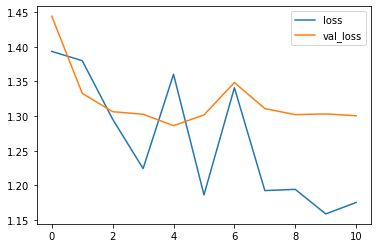

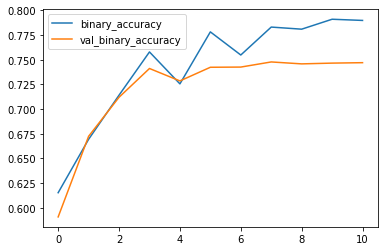

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(patience=2)

EPOCHS = 100
STEPS_PER_EPOCH = ds_info.splits['train'].num_examples // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[early_stopping, lr_schedule],
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [6]:
model.save('simple-cnn-trained')